In [ ]:
# Code for the Book: International Stock Picking A.I. INVESTOR: A Guide to Build.
# Website: ai-investor.net
# Code needs am "All-In-One" subscription from the (presumably) nice people at https://eodhistoricaldata.com/. 
# Check the book text to see if they have changed their service since mid-2021.

# Damon Lee 2021

# Feel free to fork this code for others to see what can be done with it.

In [ ]:
myToken = 'ABC123.XXXXXX.84098767' # Own token from EODHistoricalData

In [2]:
from myFunctions import *

# Get Stock Price Series For One Company

In [3]:
import pandas as pd
import requests
from io import StringIO # read string as file for pandas

def get_eod_data(startDate, 
                 endDate, 
                 symbol='AAPL.US', 
                 api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX', 
                 session=None):
    '''
    Gets price series data between startDate and endDate.
    Can set endDate to the future for up to present day price series.
    Does not raise exception if there is an error, instead writes to 
    StockWithIssues.txt.
    Returns a DataFrame where Date is NOT the index col.
    '''
    if session is None:
        session = requests.Session()
    url = 'https://eodhistoricaldata.com/api/eod/%s' % symbol
    params = {'api_token': api_token, 'from':startDate, 'to':endDate}
    r = session.get(url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), 
                         skipfooter=1, 
                         parse_dates=[0], 
                         engine='python')# index_col=0
        return df
    else:
        with open("StockWithIssues.txt", "a") as myfile:
            myfile.write(symbol+' '+str(r.status_code)+\
                         ' '+str(r.reason)+' '+str(url)+'\n')
            myfile.close()
        return pd.DataFrame()

In [4]:
priceSeries = get_eod_data('2010-01-01', '2021-12-30', symbol='GAW.LSE', api_token=myToken)
priceSeries.head()

,Date,Open,High,Low,Close,Adjusted_close,Volume
0,2010-01-04,250.0,258.05,246.95,246.950,245.1572,577
1,2010-01-05,252.5,255.00,247.00,250.526,248.7073,223
2,2010-01-06,295.0,334.00,285.00,333.850,331.4264,248243
3,2010-01-07,332.5,340.00,318.00,328.000,325.6188,8209
4,2010-01-08,325.0,325.00,315.20,315.200,312.9117,5389


<AxesSubplot:xlabel='Date'>

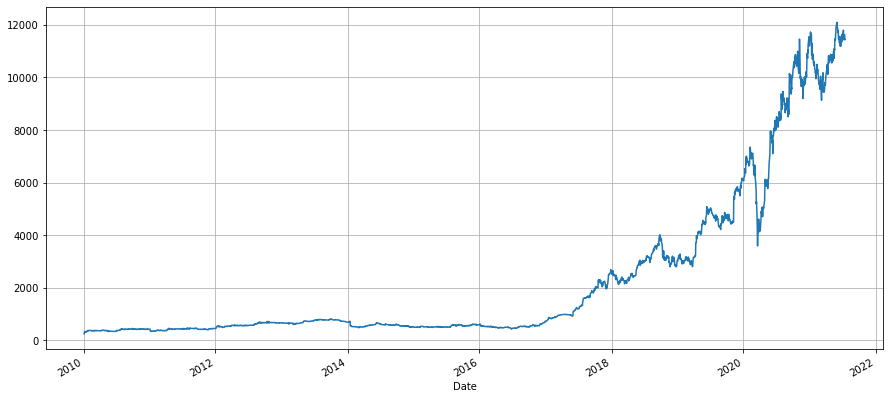

In [5]:
from matplotlib import pyplot as plt

priceSeries.index = priceSeries['Date']
plt.figure(figsize = (15,7))
priceSeries['Adjusted_close'].plot(grid=True)

# Get Price On Publication And A Year Afterward Too

In [10]:
stockData=pd.read_csv('stockData_2021.csv')
stockData['date'] = pd.to_datetime(stockData['date']) # fix the date format
print(stockData.shape)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,10,12,14,22,23,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(536960, 152)


In [11]:
import os

def getPriceData(stockDataInput, threadNo=0):
    '''
    For finding the price difference corresponding to the stockData file.
    
    Input: the stockDataFile as a DataFrame
    Output: Writes many price files in a folder. One per ticker in stockData,
    containing the start and end prices.   
    
    1 API call for each ticker.
    
    After running this function, can combine all the price data files to 
    create y-vector DataFrame for Machine Learning on stock fundamental data.
    As this function just dumps data into files, it can be run in parallel.
    '''
    print('Thread working', threadNo)

    if not os.path.isdir('PriceDataFiles'):
        print('Creating PriceDataFiles Folder')
        os.mkdir('PriceDataFiles')
    
    # The data columns we want to store start and end price data for
    pcols = ['ticker','startDate','startOpen','startHigh','startLow',
             'startClose','startAdjusted_close','startVolume',
             'endDate','endOpen','endHigh','endLow',
             'endClose','endAdjusted_close','endVolume']
    
    # Obtaining the full list of stock tickers we have.
    # Need to make sure US stocks end with .US
    usaStocksBooleanMask = stockDataInput['Exchange'].isin(['NYSE MKT', 
                                                           'NASDAQ', 
                                                           'PINK', 
                                                           'NYSE ARCA', 
                                                           'NYSE'])
    stockDataInput.loc[usaStocksBooleanMask, 'Exchange'] = 'US'
    stockDataSeriesOfTickers = stockDataInput['Code'].astype(str) + \
                                '.' + \
                                stockDataInput['Exchange'].astype(str)
    
    # Iterate through every ticker that exists
    for uniqueTicker in stockDataSeriesOfTickers.unique():
        
        # Grab the complete price data for each ticker. 
        
        # (1) get the latest possible date we need price for.
        # One year after latest report, plus publish date is 4 months after that.
        latestDateToGetPriceFor = \
            stockDataInput[stockDataSeriesOfTickers==uniqueTicker]['date'].max()\
            + pd.Timedelta(days=365) \
            + pd.Timedelta(days=120) 

        # (2) get the earliest date we need price for
        earliestDateToGetPriceFor = \
            stockDataInput[stockDataSeriesOfTickers==uniqueTicker]['date'].min()
        
        # (3) Get the price series for that whole period
        prices = get_eod_data(earliestDateToGetPriceFor, 
                              latestDateToGetPriceFor, 
                              symbol=uniqueTicker, 
                              api_token=myToken)
        
        priceData = pd.DataFrame(columns=pcols)
        
        # Iterate though the annual reports for a single ticker and extract the 
        # prices on particular days corresponding to the annual reports.
        for i, row in stockDataInput[stockDataSeriesOfTickers == \
                                     uniqueTicker].iterrows():
            
            

            # Get publication date when the public get access to see the report.
            publicationDate = row['date'] + pd.Timedelta(days=120)
            
            # Get the date 1 year after this time. So we have start and end.
            yearAfterPublicationDate = publicationDate + pd.Timedelta(days=365)
            
            # Dictionary to fill with the price data we want.
            rowDict = {'ticker':None, 
                       'startDate':None, 'startOpen':None, 'startHigh':None, 
                       'startLow':None, 'startClose': None, 
                       'startAdjusted_close':None, 'startVolume':None,
                       'endDate':None, 'endOpen':None, 'endHigh':None, 
                       'endLow':None, 'endClose': None, 
                       'endAdjusted_close':None, 'endVolume':None}

            rowDict['ticker'] = uniqueTicker # Filling the Dictionary

            priceStart = pd.DataFrame()

            # If there is price data, extract the start and end date data,
            # or data as close to those dates as we can.
            if not prices.empty:
                pricesStart=pd.DataFrame()
                pricesStart=prices[prices['Date'].between(publicationDate,
                                                          publicationDate + \
                                                          pd.Timedelta(days=14))]
                if not pricesStart.empty:
                    # get soonest date of 2 week window
                    priceStart = pricesStart.iloc[[0]] 
                    rowDict['startDate'] = priceStart['Date'].iloc[0]
                    rowDict['startOpen'] = priceStart['Open'].iloc[0]
                    rowDict['startHigh'] = priceStart['High'].iloc[0]
                    rowDict['startLow'] = priceStart['Low'].iloc[0]
                    rowDict['startClose'] = priceStart['Close'].iloc[0]
                    rowDict['startAdjusted_close'] = \
                                        priceStart['Adjusted_close'].iloc[0]
                    rowDict['startVolume'] = priceStart['Volume'].iloc[0]

                pricesEnd = pd.DataFrame()
                pricesEnd=prices[prices['Date'].between(yearAfterPublicationDate,
                                                        yearAfterPublicationDate\
                                                        + pd.Timedelta(days=14))]
                if not pricesEnd.empty:
                    priceEnd = pricesEnd.iloc[[0]] #get soonest d of 2week window
                    rowDict['endDate'] = priceEnd['Date'].iloc[0]
                    rowDict['endOpen'] = priceEnd['Open'].iloc[0]
                    rowDict['endHigh'] = priceEnd['High'].iloc[0]
                    rowDict['endLow'] = priceEnd['Low'].iloc[0]
                    rowDict['endClose'] = priceEnd['Close'].iloc[0]
                    rowDict['endAdjusted_close'] = \
                                        priceEnd['Adjusted_close'].iloc[0]
                    rowDict['endVolume'] = priceEnd['Volume'].iloc[0]

            # Write the data to file, in the folder called PriceDataFiles.
            priceData = priceData.append(pd.DataFrame(columns=pcols, 
                                                      data=rowDict, 
                                                      index=[i]))
        priceData.to_csv('PriceDataFiles/'+str(i)+'.csv', header=False)
        pass

# Get Price on Publication and a Year Afterward (Serial one CPU core)

In [237]:
#getPriceData(stockData) # Get all the stock prices, single CPU thread

#stockDataIn = stockData[:10] # Get first 10 rows of price data
stockDataIn = stockData[:100000] # get first 100k rows of stock prices
getPriceData(stockDataIn)

Thread working 0


# Get Price on Publication and a Year Afterward (Parallel)

In [43]:
#536960 rows total.
stockDataThreadList = [stockData.loc[:200000], 
                       stockData.loc[200000:400000], 
                       stockData.loc[400000:]]

# If it takes too long, can split up the parallel jobs in batches and do manually.
#stockDataThreadList = [stockData.loc[:3000], stockData.loc[3000:6000], stockData.loc[6000:9000]]
#stockDataThreadList = [stockData.loc[9000:12000], stockData.loc[12000:15000], stockData.loc[15000:18000]]

In [44]:
# When running this cell, might look like nothing is happening
# Look at the folder, price data files are being dumped there.

import threading
l = len(stockDataThreadList)

thread_list = []
for i in range(l):
    thread = threading.Thread(target=getPriceData, 
                              args=(stockDataThreadList[i],i))
    thread_list.append(thread)
    thread.start()

Thread working 0
Thread working 1
Thread working 2


In [27]:
# See if the thread is alive.
for i in thread_list:
    print(i.is_alive())

False
False
False


# Combine Price Files to Correspond to StockData.csv

In [29]:
import pandas as pd
import os
import numpy as np


listOfPriceFiles = os.listdir('PriceDataFiles')

pcols = ['ticker','startDate','startOpen','startHigh','startLow',
         'startClose','startAdjusted_close','startVolume',
         'endDate','endOpen','endHigh','endLow',
         'endClose','endAdjusted_close','endVolume']
priceDataDataFrame = pd.DataFrame(columns=pcols)

count=0
for file in listOfPriceFiles:
    count+=1
    priceDataDataFrame = priceDataDataFrame.append(\
                         pd.read_csv('PriceDataFiles/'+str(file), 
                                     names=pcols))
    print('Read the', count, 'th file', end='\r')
    

In [32]:
priceDataDataFrame.sort_index(inplace=True)
priceDataDataFrame=priceDataDataFrame[~priceDataDataFrame.index.duplicated()]
priceDataDataFrame.to_csv('priceData_2021.csv')

# Filter both priceData and stockData

In [18]:
# No realy need, unless you want cut-down stockData and priceData. We use X and y to select stocks anyway
'''# Read in both files
stockData=pd.read_csv('stockData_2021.csv')
priceData=pd.read_csv('priceData_2021.csv', index_col=0)

# Remove problem lines from priceData
priceData = priceData.dropna()
# Remove corresponding lines from stockData
stockData = stockData.loc[priceData.index]

#Save both
stockData.reset_index(drop=True, inplace=True)
priceData.reset_index(drop=True, inplace=True)
stockData.to_csv('stockData_2021_filtered.csv')
priceData.to_csv('priceData_2021_filtered.csv')'''

C:\Users\G50\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0,10,12,14,22,23,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
